# ORENIST Classification Example

Note: This notebook is desinged to run with Python3 and CPU (no GPU) runtime.

![Python 3 and CPU runtime](https://raw.githubusercontent.com/enakai00/colab_tfbook/master/docs/imgs/runtime_cpu.png)

####[OCE-01]
Import modules and set random seeds.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras.datasets import mnist

np.random.seed(20190223)
tf.set_random_seed(20190223)

Using TensorFlow backend.


####[OCE-02]
Download the ORENIST dataset and store into NumPy arrays.

In [2]:
!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   151  100   151    0     0    838      0 --:--:-- --:--:-- --:--:--   838
100  553k  100  553k    0     0  1305k      0 --:--:-- --:--:-- --:--:-- 8898k


####[OCE-03]
Define fixed convolutional filters to extract vertical and horizontal edges.

In [0]:
def edge_filter(shape=None, dtype=None):
    filter0 = np.array(
            [[ 2, 1, 0,-1,-2],
             [ 3, 2, 0,-2,-3],
             [ 4, 3, 0,-3,-4],
             [ 3, 2, 0,-2,-3],
             [ 2, 1, 0,-1,-2]]) / 23.0
    filter1 = np.array(
            [[ 2, 3, 4, 3, 2],
             [ 1, 2, 3, 2, 1],
             [ 0, 0, 0, 0, 0],
             [-1,-2,-3,-2,-1],
             [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5, 5, 1, 2])
    filter_array[:, :, 0, 0] = filter0
    filter_array[:, :, 0, 1] = filter1

    return filter_array

####[OCE-04]
Define a model to classify the ORENIST dataset with the fixed filters.

In [4]:
model = models.Sequential()
model.add(layers.Reshape((28, 28, 1), input_shape=(28*28,), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same',
                        kernel_initializer=edge_filter,
                        use_bias=False,
                        name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.Lambda(lambda x: keras.backend.relu(x-0.2), name='cut_off'))
model.add(layers.MaxPooling2D((2, 2), name='max_pooling'))

model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(2, activation='tanh', name='hidden'))
model.add(layers.Dense(3, activation='softmax', name='softmax'))
                       
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter (Conv2D)         (None, 28, 28, 2)         50        
_________________________________________________________________
abs (Lambda)                 (None, 28, 28, 2)         0         
_________________________________________________________________
cut_off (Lambda)             (None, 28, 28, 2)         0         
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 14, 14, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
hidd

####[OCE-05]
Compile the model using the Adam optimizer, and Cross entroy as a loss function.

In [0]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['acc'])

####[OCE-06]
Train the model.

In [6]:
history = model.fit(images, labels,
                    batch_size=len(images), epochs=100, verbose=0)

Instructions for updating:
Use tf.cast instead.


####[OCE-07]
Plot a chart to see the accuracy of the model. It achieves tha 100% accuracy.

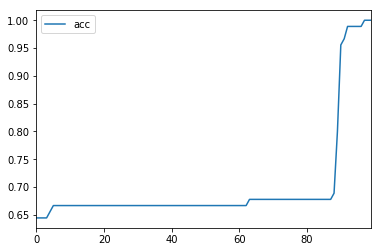

In [7]:
DataFrame({'acc': history.history['acc']}).plot()

####[OCE-08]
Define a model to extract outputs from the hidden layer.

In [0]:
layer_outputs = [model.get_layer('hidden').output]
model2 = models.Model(inputs=model.input, outputs=layer_outputs)

####[OCE-09]
Plot a chart to show the values of $(z_1, z_2)$ for each image.

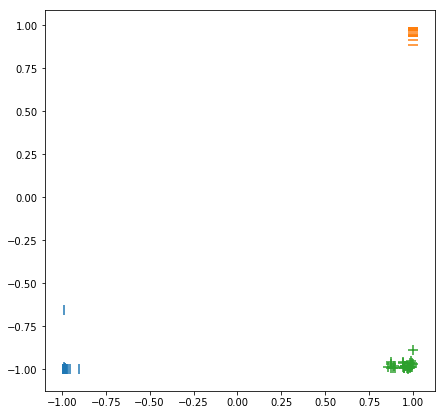

In [9]:
hidden_vals = model2.predict(images)

z1_vals = [[],[],[]]
z2_vals = [[],[],[]]

for hidden_val, label in zip(hidden_vals, labels):
    label_num = np.argmax(label)
    z1_vals[label_num].append(hidden_val[0])
    z2_vals[label_num].append(hidden_val[1])
    
fig = plt.figure(figsize=(7, 7))
subplot = fig.add_subplot(1, 1, 1)
#subplot.grid(None)
subplot.scatter(z1_vals[0], z2_vals[0], s=100, marker='|')
subplot.scatter(z1_vals[1], z2_vals[1], s=100, marker='_')
subplot.scatter(z1_vals[2], z2_vals[2], s=100, marker='+')